In [11]:
from gfn import GFNAgent

In [12]:
agent = GFNAgent(epochs=200)

First, let's take a look at the environment. The default is a 2D 8x8 grid with high reward in the corners.

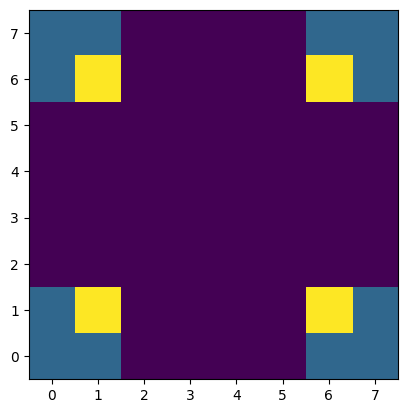

In [13]:
agent.env.plot_reward_2d()

We can also look at the model structure. Notice that in this implementation, the learned parameter `z0` is separate from the neural net, and that the neural net has two output "heads": `foward_policy` and `backward_policy`. 

In [14]:
agent.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 2, 8)]       0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 16)           0           ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 32)           544         ['flatten_1[0][0]']              
                                                                                                  
 dense_2 (Dense)                (None, 32)           1056        ['dense_1[0][0]']                
                                                                                            

In [15]:
agent.z0

<tf.Variable 'z0:0' shape=() dtype=float32, numpy=0.0>

For this demonstration, we'll just show that the GFlowNet can learn a policy that generates trajectories proportional to the reward. To do that, we'll first sample a large training set using the untrained, random policy.

157/157 [==============================] - 1s 4ms/step


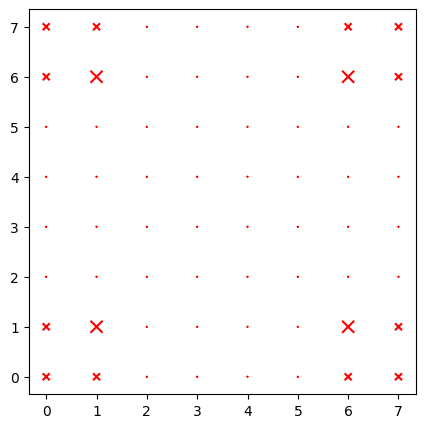

In [16]:
agent.sample(5000)
agent.plot_sampled_data_2d()

In [17]:
u_modes, u_positions = agent.count_modes()
print(f'There are {u_modes} unique modes and {u_positions} unique positions in the training data.')

There are 4 unique modes and 64 unique positions in the training data.


Before training, the policy is uniform. The likelihood of transitioning vertically or laterally (arrows) or terminating (red octogon) is essentially uniform at every point.

The probability of terminating at each position is plotted below, and we can see that without training, it looks nothing like the reward environment we plotted above. The termination probabilities are large enough, that any trajectory is unlikely to leave the origin (bottom left).

2/2 [==============================] - 0s 4ms/step


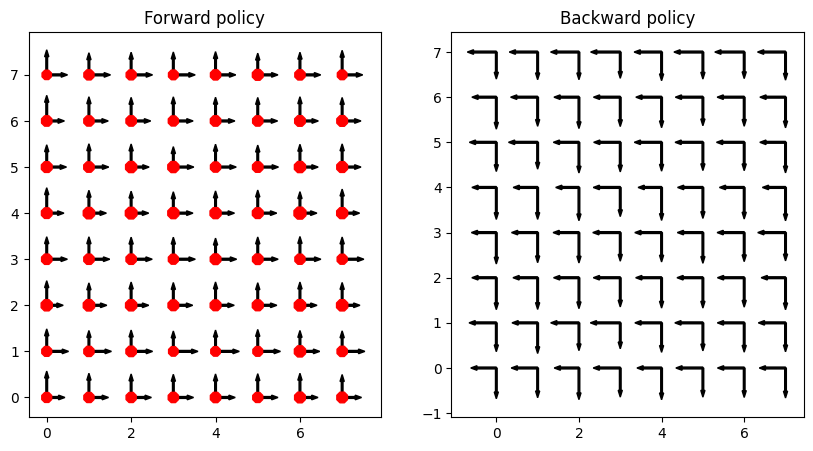

In [18]:
agent.plot_policy_2d()

63/63 [==============================] - 0s 2ms/step


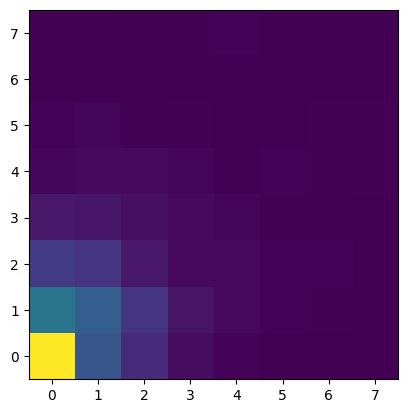

In [19]:
l1_error_before = agent.compare_env_to_model_policy()

Let's train it and see if we can do better!

In [20]:
agent.train()

Start training...
Epoch: 0 Loss: 5.801247596740723
Epoch: 9 Loss: 1.7453864812850952
Epoch: 18 Loss: 1.0872623920440674
Epoch: 27 Loss: 0.7756181359291077
Epoch: 36 Loss: 0.41288065910339355
Epoch: 45 Loss: 0.6869039535522461
Epoch: 54 Loss: 0.6046685576438904
Epoch: 63 Loss: 0.5822099447250366
Epoch: 72 Loss: 0.551060140132904
Epoch: 81 Loss: 0.404883474111557
Epoch: 90 Loss: 0.32391783595085144
Epoch: 99 Loss: 0.1387174278497696
Epoch: 108 Loss: 0.16178882122039795
Epoch: 117 Loss: 0.08019421249628067
Epoch: 126 Loss: 0.09060747921466827
Epoch: 135 Loss: 0.10926701873540878
Epoch: 144 Loss: 0.22021713852882385
Epoch: 153 Loss: 0.029513390734791756
Epoch: 162 Loss: 0.016581661999225616
Epoch: 171 Loss: 0.03896377608180046
Epoch: 180 Loss: 0.02097284235060215
Epoch: 189 Loss: 0.008390776813030243
Epoch: 198 Loss: 0.024328291416168213


Let's plot the trained policy and sample from it to get a probability distribution over the environment:

2/2 [==============================] - 0s 2ms/step


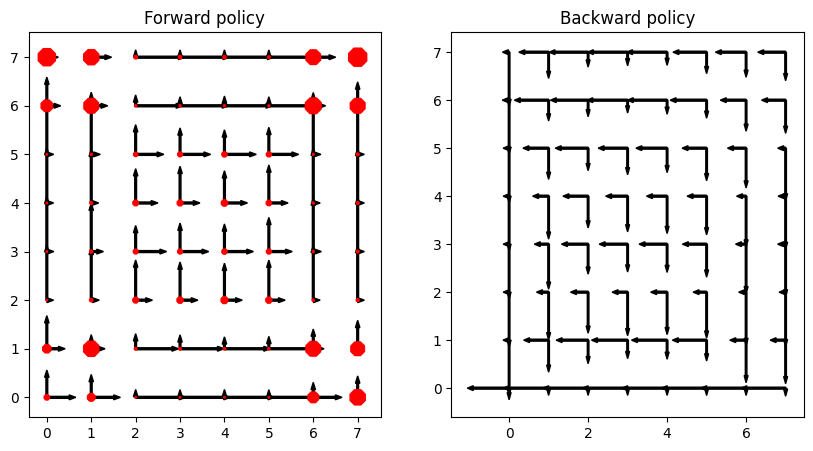

In [21]:
agent.plot_policy_2d()

63/63 [==============================] - 0s 2ms/step


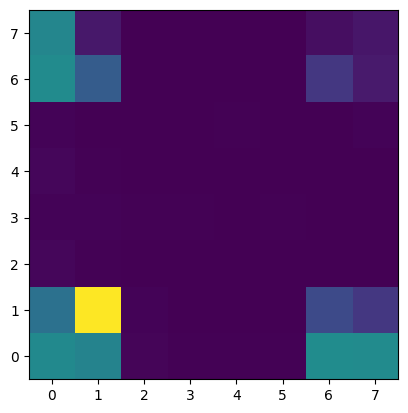

In [22]:
l1_error_after = agent.compare_env_to_model_policy()

In [23]:
print(f'L1 error before {l1_error_before:.2f} and after {l1_error_after:.2f}')

L1 error before 1.49 and after 0.76


While not perfect, the model has certainly learned to generate trajectories through the environment with probability proportional to the reward! It's a far better approximation than the untrained policy, and you can imagine that it would get better with some tweaks (e.g. more training, different optimizer, etc.)

In [24]:
l = agent.sample_trajectories(2)

1/1 [==============================] - 0s 32ms/step


In [25]:
l[0].shape, l[1].shape

((2, 16, 2), (2, 15, 3))

In [38]:
import tensorflow as tf
one_hot_positions = tf.one_hot(l[0][0], 8, axis=-1)
one_hot_positions[0]

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [53]:
import tensorflow_probability as tfp
tfd = tfp.distributions
for i, action in enumerate(tfd.Categorical(probs=l[1][0]).sample().numpy()):
    print(action == (agent.action_space - 1))

False
False
False
False
False
False
True
False
False
False
False
False
False
False
False


In [46]:
l[1][0]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)